<a href="https://colab.research.google.com/github/ShiwangiMishra-Git/DeepLearningFinalProject/blob/main/Object_Detection_with_Deep_Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Model Details**


 We trained and tested Hierarchical Object Detection model coupled with Deep Reinforcement Learning on Pascal VOC2007 Dataset for "Bottle Class". We chose  bottle class for our training and testing becasue it amounts to a large amount of trash in most of the places. Previously the model was only trained for Aeroplane class of Pascal VOC2007 Dataset. The key idea is to focus on those parts of the image that contain richer information and zoom on them. We train an intelligent agent that, given an image window, is capable of deciding where to focus the attention among five different predefined region candidates (smaller windows). This procedure is iterated providing a hierarchical image analysis.We compare two different candidate proposal strategies to guide the object search: with and without overlap. Results show that more reduced amount of region proposals generated by the reinforcement learning agent allows considering to extract features for each location without sharing
convolutional computation among regions.

Orginal model trained on aeroplane can be refrered from https://github.com/imatge-upc/detection-2016-nipsws 

This model uses two different (VGG-16) sub models for visual feature extraction which are used to train the final Deep Q-Network.

These models are:

 *ImageZooms model:* Each region is resized to
224x224 and its visual descriptors correspond to the feature maps from Pool5 layer of VGG-16

*Pool45-Crops model:* Image at full-resolution is forwarded into VGG-16 through
Pool5 layer

**Deep Q-network:**

The two VGG models for feature extraction result into a feature map of 7x7 which is fed to the common
block of the architecture. The region descriptor and the memory vector are the input of the Deep
Q-network that consists of two fully connected layers of 1024 neurons each.
Each fully connected layer is followed by a ReLU activation function and is trained with dropout.  Finally the
output layer corresponds to the  6 possible actions of the agent.

 Following are the functions that are used to configure Q network

In [ ]:
import torch
import random
import torchvision
import torch.nn.init as init
import torch.nn as nn
from collections import namedtuple
from features import *
from random import random
import random as rand

# Different actions that the agent can do
number_of_actions = 6
# Actions captures in the history vector
actions_of_history = 4
# Visual descriptor size
visual_descriptor_size = 25088
# Reward movement action
reward_movement_action = 1
# Reward terminal action
reward_terminal_action = 3
# IoU required to consider a positive detection
iou_threshold = 0.5


Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return rand.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

    
def get_state(image, history_vector, model_vgg, dtype=torch.cuda.FloatTensor):
    image_feature = get_conv_feature_for_image(image, model_vgg,dtype)
    image_feature = image_feature.view(1,-1)
    history_vector_flatten = history_vector.view(1,-1).type(dtype)
    state = torch.cat((image_feature, history_vector_flatten), 1)
    return state


# FIFO
def update_history_vector(history_vector, action):
    action_vector = torch.zeros(number_of_actions)
    action_vector[action-1] = 1
    size_history_vector = len(torch.nonzero(history_vector))    
    if size_history_vector < actions_of_history:
        history_vector[size_history_vector][action-1] = 1
    else:
        for i in range(actions_of_history-1,0,-1):
            history_vector[i][:] = history_vector[i-1][:]
        history_vector[0][:] = action_vector[:] 
    return history_vector


def get_q_network(weights_path="0"):
    model = nn.Sequential(
                nn.Linear(25112, 1024),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(1024, 1024),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(1024, 6),
    )
    if weights_path != "0":
        model.load_state_dict(torch.load(weights_path))
    # init weights by xavier_normal, it may be different with the author's implements
    def weights_init(m):
        if isinstance(m, nn.Linear):
            init.xavier_normal(m.weight.data)
    model.apply(weights_init)
    return model


def get_reward_movement(iou, new_iou):
    if new_iou > iou:
        reward = reward_movement_action
    else:
        reward = - reward_movement_action
    return reward


def get_reward_trigger(new_iou):
    if new_iou > iou_threshold:
        reward = reward_terminal_action
    else:
        reward = - reward_terminal_action
    return reward

### **Training Q network with Pascal VOC bottle class**

In [ ]:
import torch
import torchvision
import torch.optim as optim
from torch.autograd import Variable
from image_helper import *
from parse_xml_annotations import *
from features import *
#from reinforcement import *
from metrics import *
from collections import namedtuple
import time
import os
import numpy as np
import random as rand
from random import random


os.environ["CUDA_VISIBLE_DEVICES"] = "1"
path_voc = "datas/VOCdevkit/VOC2007"

# get models 
print("load models")

model_vgg = getVGG_16bn("models")
model_vgg = model_vgg.cuda()
model = get_q_network()
model = model.cuda()

# define optimizers for each model
optimizer = optim.Adam(model.parameters(),lr=1e-6)
criterion = nn.MSELoss().cuda()   

# get image datas
path_voc_1 = "datas/VOCdevkit/VOC2007"
class_object = '1'
image_names_1, images_1 = load_image_data(path_voc_1, class_object)
image_names = image_names_1 
images = images_1

print("bottle_trainval image:%d" % len(image_names))

# define the Pytorch Tensor
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

# define the super parameter
epsilon = 1.0
BATCH_SIZE = 100
GAMMA = 0.90
CLASS_OBJECT = 1
steps = 10
epochs = 50
memory = ReplayMemory(1000)

def select_action(state):
    if rand.random() < epsilon:
        action = np.random.randint(1,7)
    else:
        qval = model(Variable(state))
        _, predicted = torch.max(qval.data,1)
        action = predicted[0] + 1
    return action


Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
def optimizer_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    
    non_final_mask = ByteTensor(tuple(map(lambda s: s is not None, batch.next_state)))
    next_states = [s for s in batch.next_state if s is not None]
    non_final_next_states = Variable(torch.cat(next_states), 
                                     volatile=True).type(Tensor)
    state_batch = Variable(torch.cat(batch.state)).type(Tensor)
    action_batch = Variable(torch.LongTensor(batch.action).view(-1,1)).type(LongTensor)
    reward_batch = Variable(torch.FloatTensor(batch.reward).view(-1,1)).type(Tensor)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = model(state_batch).gather(1, action_batch)
    
    # Compute V(s_{t+1}) for all next states.
    next_state_values = Variable(torch.zeros(BATCH_SIZE, 1).type(Tensor)) 

    x = torch.tensor(model(non_final_next_states).max(1)[0])
    next_state_values[non_final_mask] = x.unsqueeze(1)
    #next_state_values[non_final_mask] = model(non_final_next_states).max(1)[0]
    
    # Now, we don't want to mess up the loss with a volatile flag, so let's
    # clear it. After this, we'll just end up with a Variable that has
    # requires_grad=False
    next_state_values.volatile = False
    
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    # Compute  loss
    loss = criterion(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# train procedure
print('train the Q-network')
for epoch in range(epochs):
    print('epoch: %d' %epoch)
    now = time.time()
    for i in range(len(image_names)):
        # the image part
        image_name = image_names[i]
        image = images[i]
        if i < len(image_names_1):
            annotation = get_bb_of_gt_from_pascal_xml_annotation(image_name, path_voc_1)
        else:
            annotation = get_bb_of_gt_from_pascal_xml_annotation(image_name, path_voc_2)            
        classes_gt_objects = get_ids_objects_from_annotation(annotation)
        gt_masks = generate_bounding_box_from_annotation(annotation, image.shape) 
         
        # the iou part
        original_shape = (image.shape[0], image.shape[1])
        region_mask = np.ones((image.shape[0], image.shape[1]))
        #choose the max bouding box
        iou = find_max_bounding_box(gt_masks, region_mask, classes_gt_objects, CLASS_OBJECT)
        
        # the initial part
        region_image = image
        size_mask = original_shape
        offset = (0, 0)
        history_vector = torch.zeros((4,6))
        state = get_state(region_image, history_vector, model_vgg)
        done = False
        for step in range(steps):
            # Select action, the author force terminal action if case actual IoU is higher than 0.5
            if iou > 0.5:
                action = 6
            else:
                action = select_action(state)
            
            # Perform the action and observe new state
            if action == 6:
                next_state = None
                reward = get_reward_trigger(iou)
                done = True
            else:
                offset, region_image, size_mask, region_mask = get_crop_image_and_mask(original_shape, offset,
                                                                   region_image, size_mask, action)
                # update history vector and get next state
                history_vector = update_history_vector(history_vector, action)
                next_state = get_state(region_image, history_vector, model_vgg)
                
                # find the max bounding box in the region image
                new_iou = find_max_bounding_box(gt_masks, region_mask, classes_gt_objects, CLASS_OBJECT)
                reward = get_reward_movement(iou, new_iou)
                iou = new_iou
            print('epoch: %d, image: %d, step: %d, reward: %d' %(epoch ,i, step, reward))    
            # Store the transition in memory
            memory.push(state, action-1, next_state, reward)
            
            # Move to the next state
            state = next_state
            
            # Perform one step of the optimization (on the target network)
            optimizer_model()
            if done:
                break
    if epsilon > 0.1:
        epsilon -= 0.1
    time_cost = time.time() - now
    print('epoch = %d, time_cost = %.4f' %(epoch, time_cost))
    
# save the whole model
Q_NETWORK_PATH = '../models/' + 'voc2012_2007_model'
torch.save(model, Q_NETWORK_PATH)
print('Complete')

###**Testing Q network with Pascal VOC bottle class:**

In [ ]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data
import torch.optim as optim
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
%matplotlib inline
from image_helper import *
from parse_xml_annotations import *
from features import *
from reinforcement import *
from metrics import *
import logging
import time
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
print("load images")
path_voc = "datas/VOCdevkit/VOC2007/JPEGTestImages"
image_names = np.array(load_images_names_in_data_set('bottle_test', path_voc))
labels = load_images_labels_in_data_set('bottle_test', path_voc)
image_names_aero = []
for i in range(len(image_names)):
    if labels[i] == '1':
        image_names_aero.append(image_names[i])
image_names = image_names_aero
images = get_all_images(image_names, path_voc)
print("bottle_test image:%d" % len(image_names))




load images
bottle_test image:212


In [ ]:
Q_NETWORK_PATH ='../models/voc2012_2007_model'
model = torch.load(Q_NETWORK_PATH)
model_vgg = getVGG_16bn("models")
model_vgg = model_vgg.cuda()

In [ ]:
def draw_bouding_box_1(annotation, img):
    new_img = Image.fromarray(img)
    draw = ImageDraw.Draw(new_img)
    length = len(annotation)
    annotation = np.array(annotation)
    for i in range(length):
        x_min = int(annotation[i,1])
        x_max = int(annotation[i,2])
        y_min = int(annotation[i,3])
        y_max = int(annotation[i,4])
        draw.line(((x_min, y_min), (x_max, y_min)), fill="red", width=3)
        draw.line(((x_min, y_min), (x_min, y_max)), fill="red", width=3)
        draw.line(((x_max, y_min), (x_max, y_max)), fill="red", width=3)
        draw.line(((x_min, y_max), (x_max, y_max)), fill="red", width=3)
    plt.figure()
    plt.imshow(new_img)

def get_annotation(offset, size_mask):
    annotation = np.zeros(5)
    annotation[3] = offset[0]
    annotation[4] = offset[0] + size_mask[0]
    annotation[1] = offset[1]
    annotation[2] = offset[1] + size_mask[1] 
    return annotation

In [ ]:
class_object = 1
steps = 10
res = []
res_step = []
res_annotations = []
for i in range(len(image_names)):
    image_name = image_names[i]
    image = images[i]
    
    # get use for iou calculation
    gt_annotation = get_bb_of_gt_from_pascal_xml_annotation(image_name, path_voc)
    original_shape = (image.shape[0], image.shape[1])
    classes_gt_objects = get_ids_objects_from_annotation(gt_annotation)
    gt_masks = generate_bounding_box_from_annotation(gt_annotation, image.shape)
    
    # the initial part
    region_image = image
    size_mask = image.shape
    region_mask = np.ones((image.shape[0], image.shape[1]))
    offset = (0, 0)
    history_vector = torch.zeros((4,6))
    state = get_state(region_image, history_vector, model_vgg)
    done = False
    
    # save the bounding box maked by agent
    annotations = []
    annotation = get_annotation(offset, size_mask)
    annotations.append(annotation)
    
    for step in range(steps):
            # Select action
            qval = model(Variable(state))
            _, predicted = torch.max(qval.data,1)
            action = predicted[0] + 1
            # Perform the action and observe new state
            if action == 6:
                next_state = None
                done = True
            else:
                offset, region_image, size_mask, region_mask = get_crop_image_and_mask(original_shape, offset,
                                                                   region_image, size_mask, action)
               
                #print(offset, size_mask, region_image.shape, region_mask.shape)
                annotation = get_annotation(offset, size_mask)
                annotations.append(annotation)
                history_vector = update_history_vector(history_vector, action)
                next_state = get_state(region_image, history_vector, model_vgg)

            # Move to the next state
            state = next_state
            if done:
                print('done!!')
                res_step.append(step)
                res_annotations.append((gt_annotation, annotations, image))
                break
                
    iou = find_max_bounding_box(gt_masks, region_mask, classes_gt_objects, class_object)
    print(iou)
    pos = 0
    reward = qval.data[0,5]
    if iou > 0.5:
        pos = 1
    print(reward)
    print(pos)
    res.append((reward, pos))

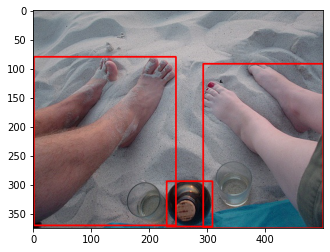

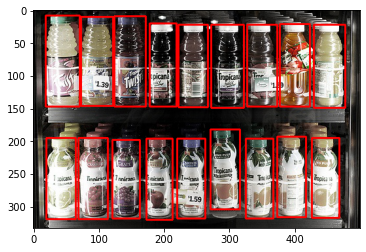

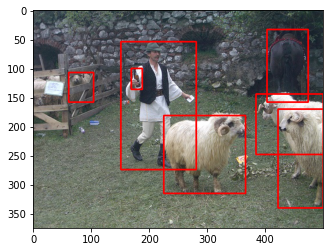

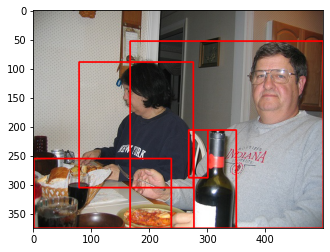

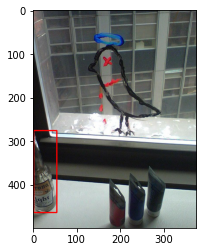

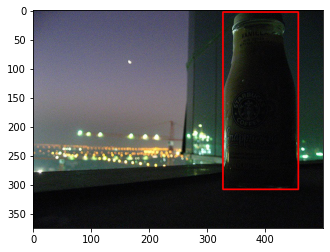

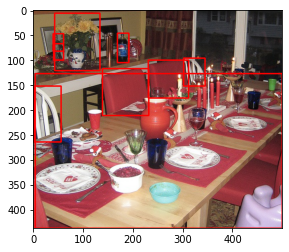

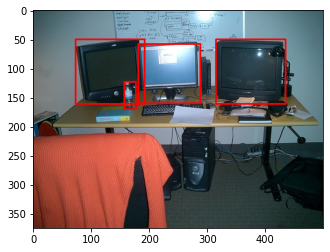

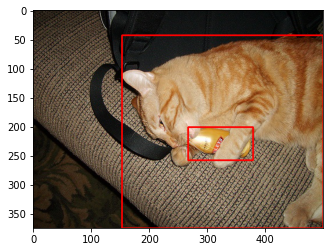

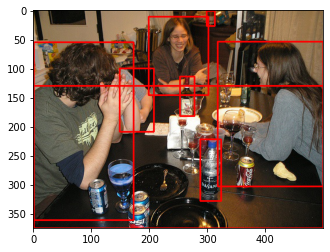

In [ ]:
begin = 170
end = begin + 10
for i in range(begin, end):
    gt_annotation, annotation, image = res_annotations[i]
    draw_bouding_box_1(gt_annotation, image)

We can see in the above results that our model has reduced the number of region proposals considerably.

###**Results:**

Text(0, 0.5, 'Number of objects')

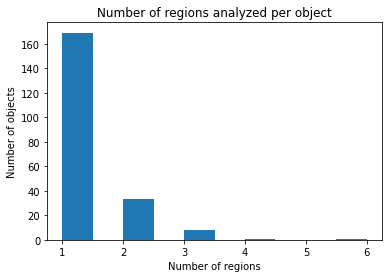

In [ ]:
res_step = np.array(res_step) + 1
plt.hist(res_step)
plt.title('Number of regions analyzed per object')
plt.xlabel('Number of regions')
plt.ylabel('Number of objects')


Above histogram shows the amount of regions analyzed by our agent in each step for objects.
We can see that the major part of objects are already found with a single step. With less than 3 steps we can almost approximate all objects we can detect. This is much lesser than the amount of region proposals as compared to R-CNN.